In [1]:
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader,ConcatDataset
import glob
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
import random, sys

# Readingtheimages 

In [2]:
tumor = []
path = './brain_tumor_dataset/yes/*.jpg'
for i in glob.iglob(path):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img=cv2.merge([r,g,b])
    tumor.append(img)

In [3]:
healthy = []
path = './brain_tumor_dataset/no/*.jpg'
for i in glob.iglob(path):
    img = cv2.imread(i)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img=cv2.merge([r,g,b])
    healthy.append(img)

In [4]:
healthy=np.array(healthy)
tumor=np.array(tumor)

In [5]:
AllImages=np.concatenate((healthy,tumor))

In [6]:
AllImages.shape

(245, 128, 128, 3)

# Visualizing Brain

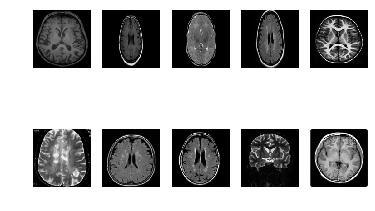

In [7]:
fig, axs = plt.subplots(2, 5)

for i in range(0,10):
    row = i // 5  # Calculate the row index for the subplot
    col = i % 5   # Calculate the column index for the subplot
    axs[row, col].imshow(healthy[i])
    axs[row, col].axis('off')  # Turn off axis for better visualization

plt.show()

In [8]:
def plot_random(healthy,tumor,num):
    healthy_imgs=healthy[np.random.choice(healthy.shape[0],num,replace=False)]
    tumor_imgs=tumor[np.random.choice(tumor.shape[0],num,replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
            
        

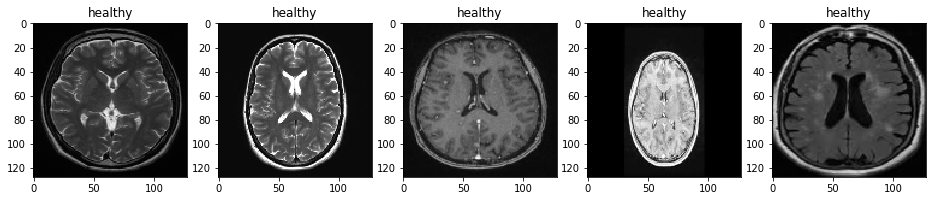

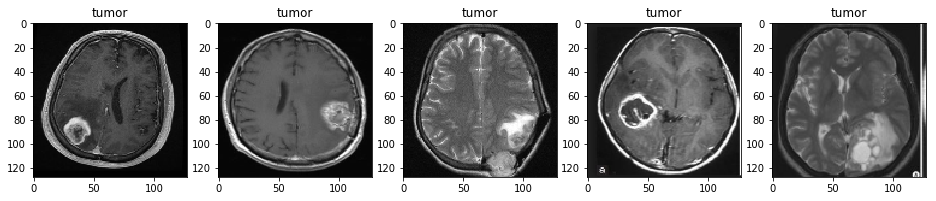

In [9]:
 plot_random(healthy,tumor,5)

# Create Torch Dataset Class

In [10]:
 class Dataset(object):
        def __getitem__(self, index): #supporting integer indexing in range from 0 to len(self)
            raise NotImplementedError
        def __len__(self): #The size of the dataset
            raise NotImplementedError
        def __add__(self,other):
            return ConcatDataset([self,other])

## Creating MRI custom dataset class

In [11]:
class MRI(Dataset):
    def __init__(self):
        healthy = []
        path = './brain_tumor_dataset/no/*.jpg'
        for i in glob.iglob(path):
            img = cv2.imread(i)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img=cv2.merge([r,g,b])
            healthy.append(img)
        
        tumor = []
        path = './brain_tumor_dataset/yes/*.jpg'
        for i in glob.iglob(path):
            img = cv2.imread(i)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img=cv2.merge([r,g,b])
            tumor.append(img)
        #the images    
        healthy=np.array(healthy,dtype=np.float32)
        tumor=np.array(tumor,dtype=np.float32)
        
        #our labels
        tumor_label=np.ones(tumor.shape[0],dtype=np.float32)
        healthy_label=np.zeros(healthy.shape[0],dtype=np.float32)
        #Concatenates
    
      
        self.images=np.concatenate((tumor,healthy),axis=0)
        self.labels=np.concatenate((tumor_label,healthy_label))
    def __len__(self) :
        return self.images.shape[0]
    
    def __getitem__(self, index): #supporting integer indexing in range from 0 to len(self)
        sample={"image":self.images[index],"label":self.labels[index]}
        return sample
    
    def normalize(self):
        self.images=self.images/255.0
        

# Creating a dataloader

## The world without dataloaders

In [12]:
mri =MRI()
mri.normalize()

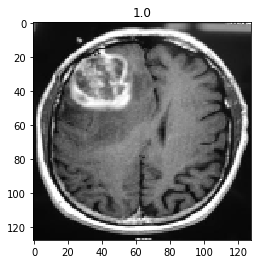

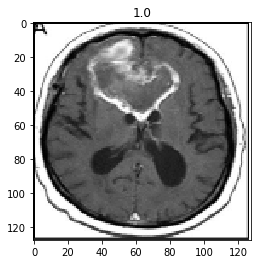

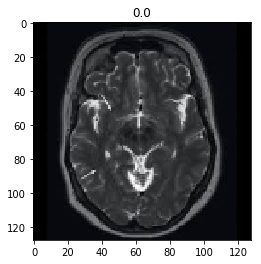

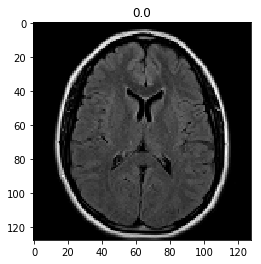

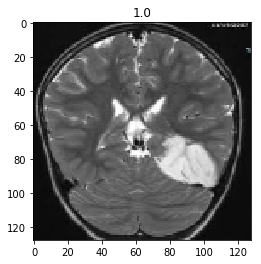

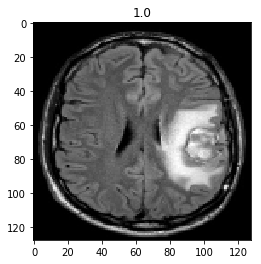

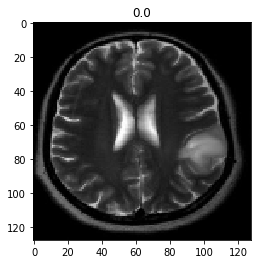

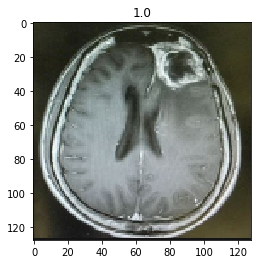

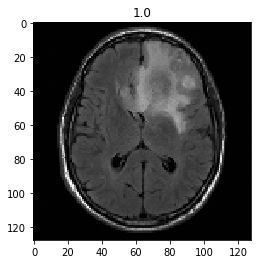

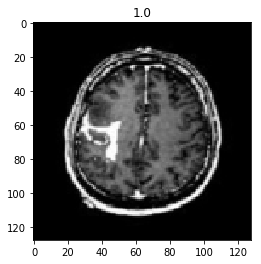

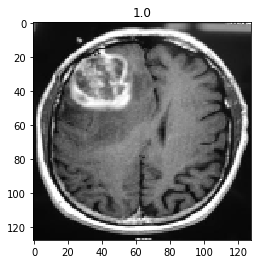

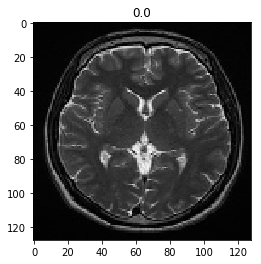

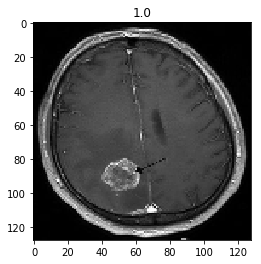

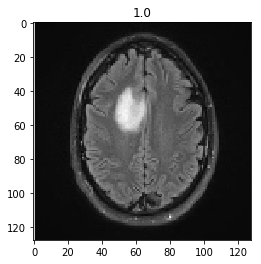

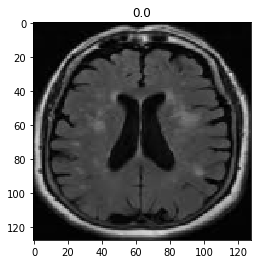

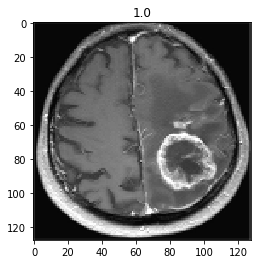

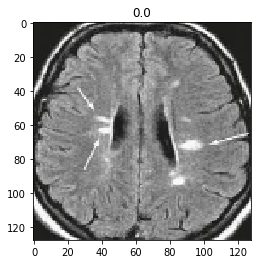

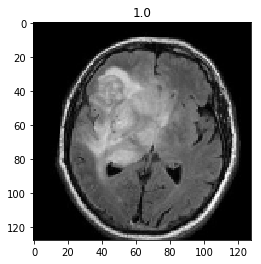

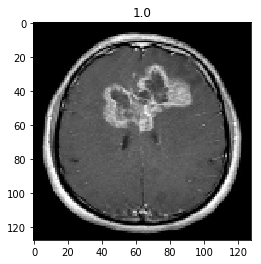

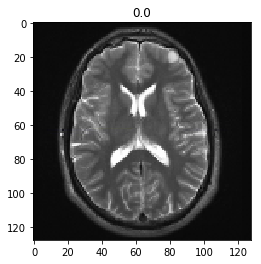

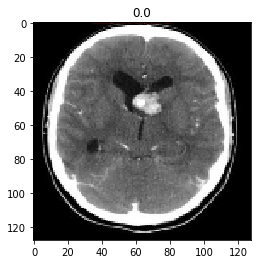

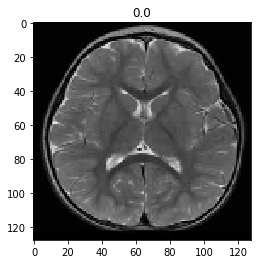

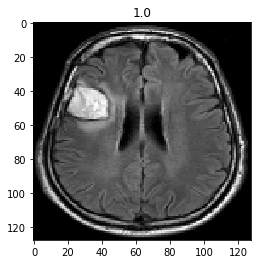

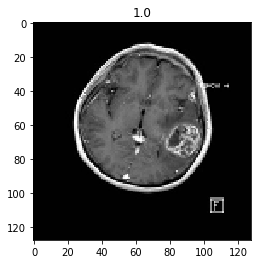

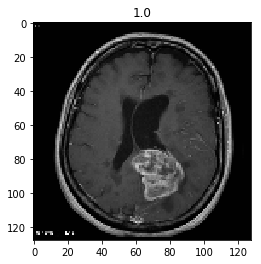

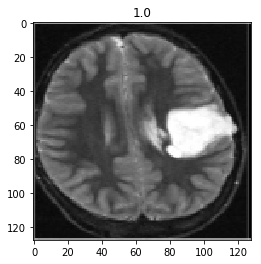

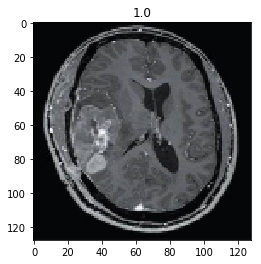

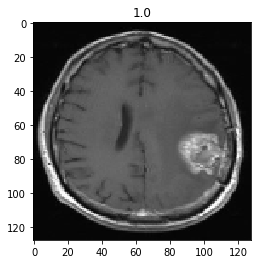

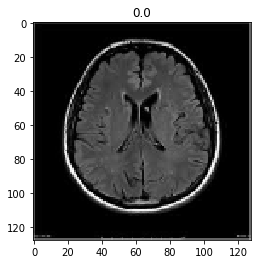

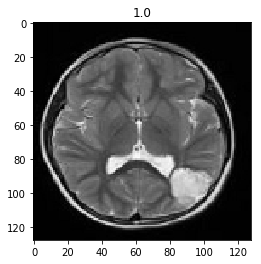

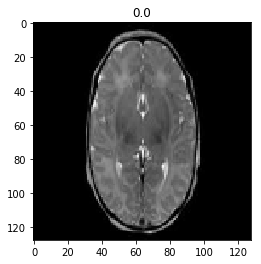

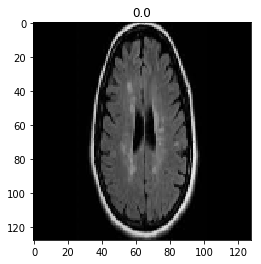

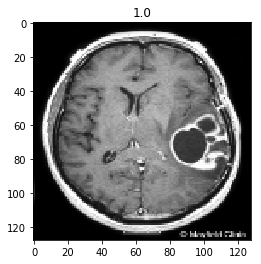

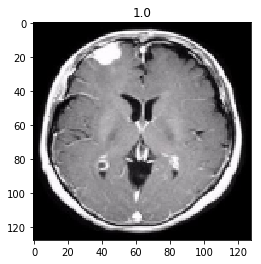

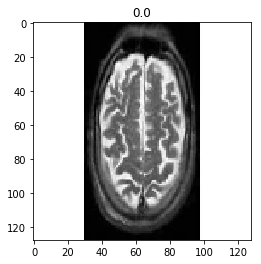

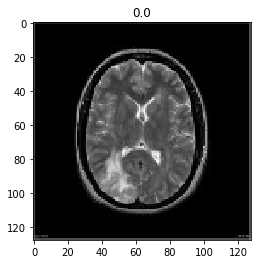

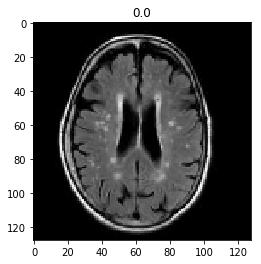

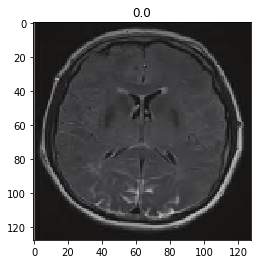

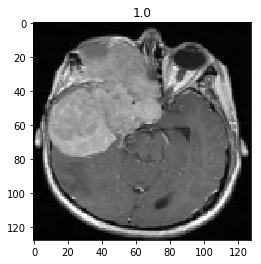

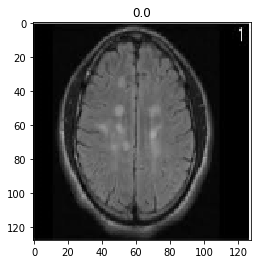

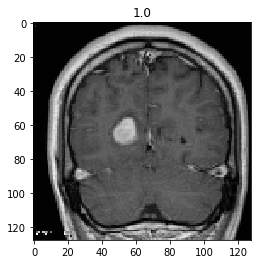

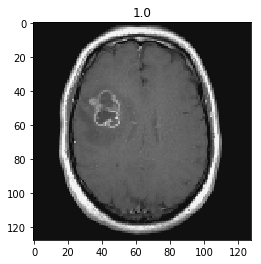

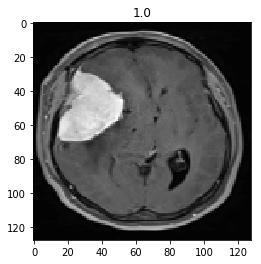

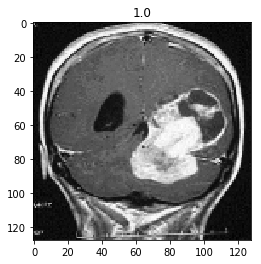

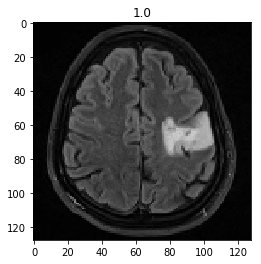

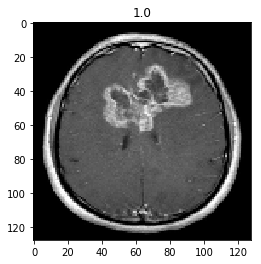

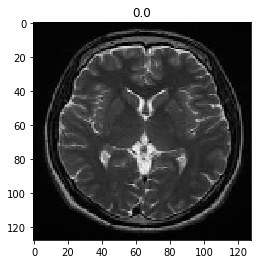

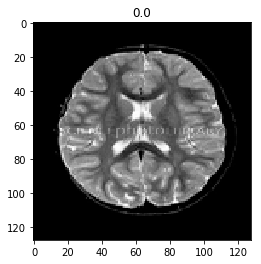

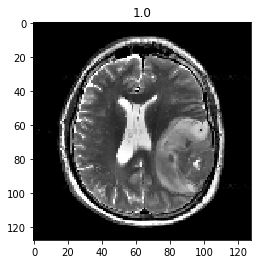

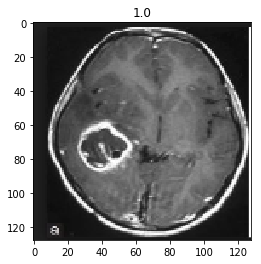

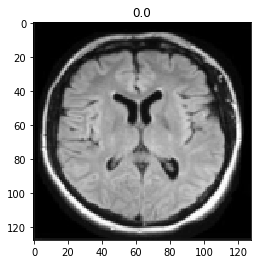

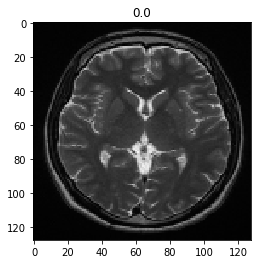

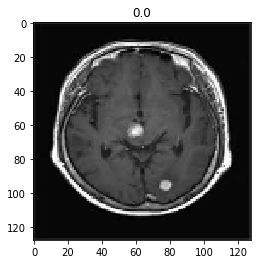

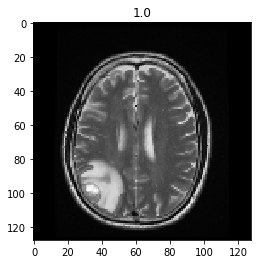

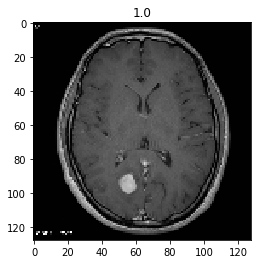

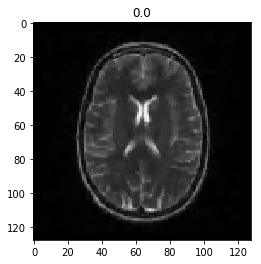

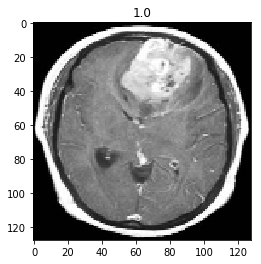

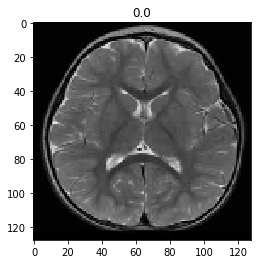

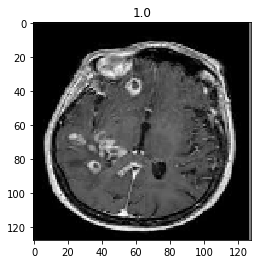

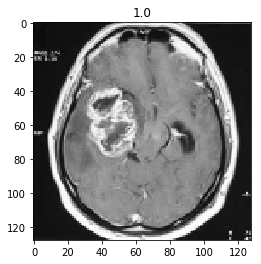

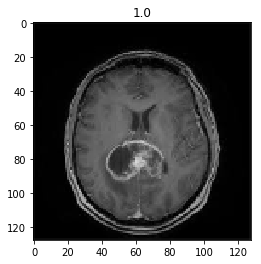

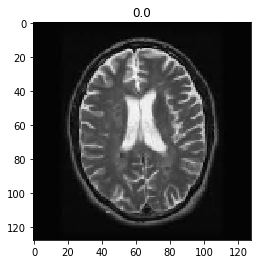

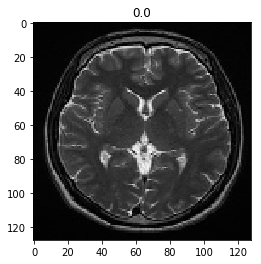

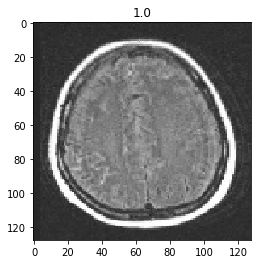

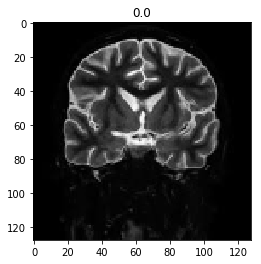

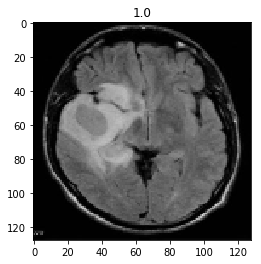

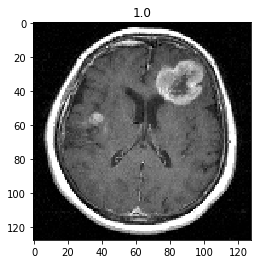

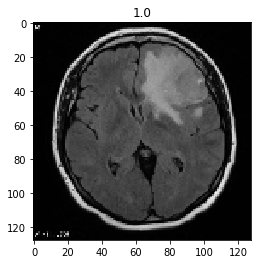

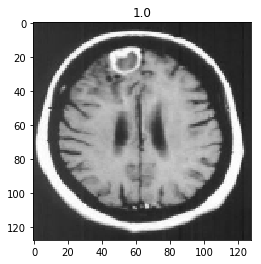

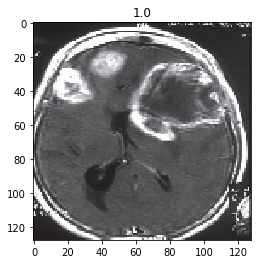

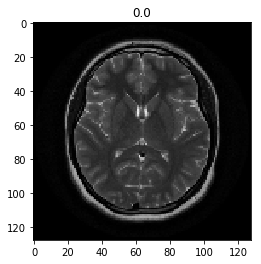

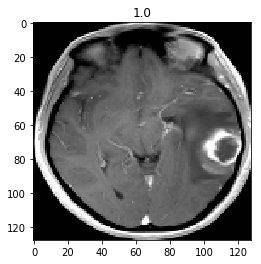

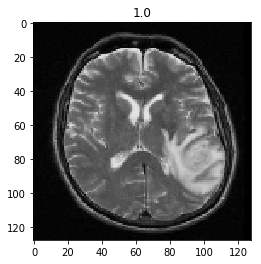

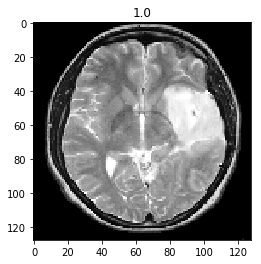

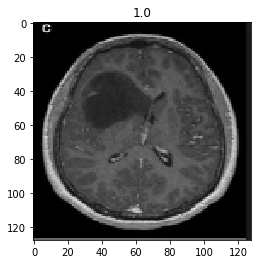

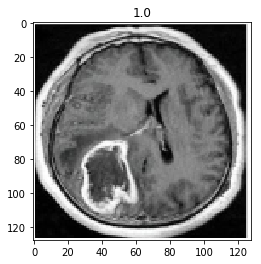

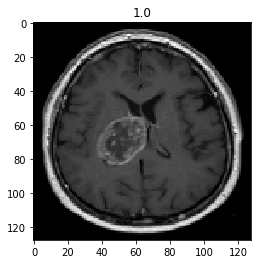

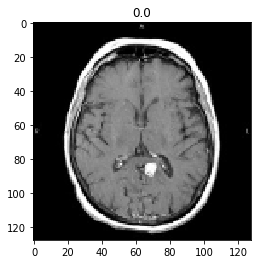

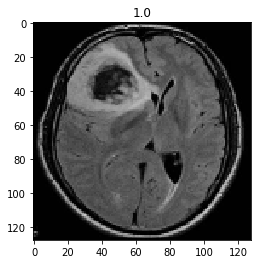

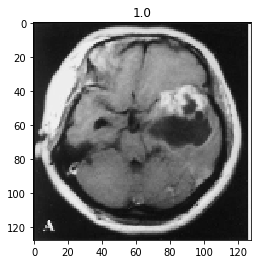

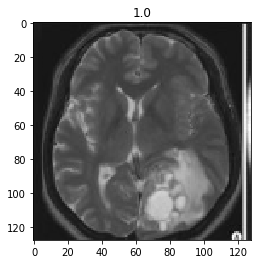

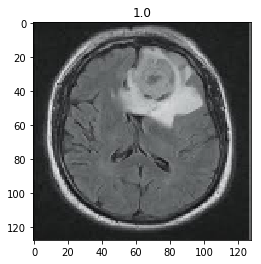

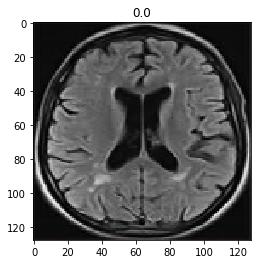

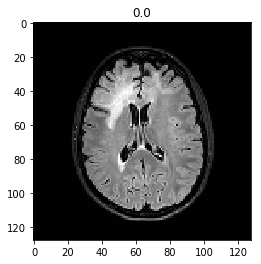

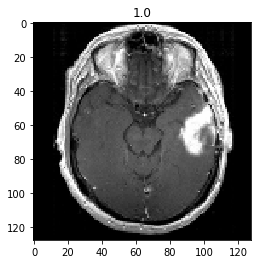

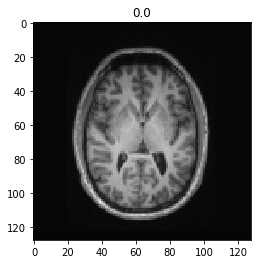

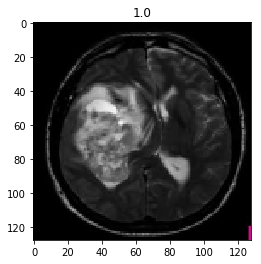

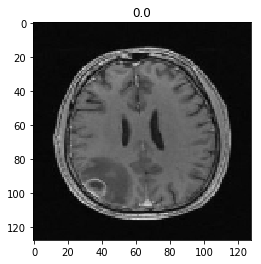

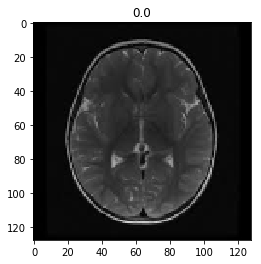

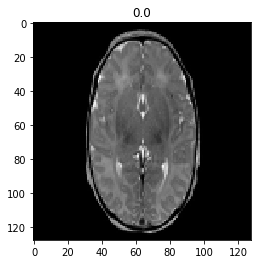

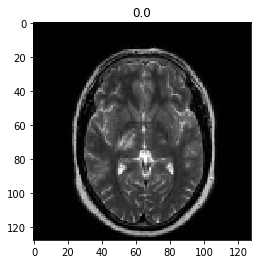

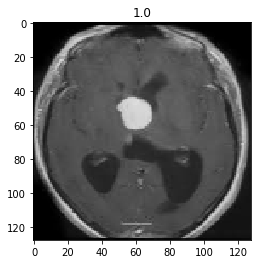

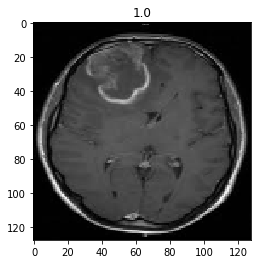

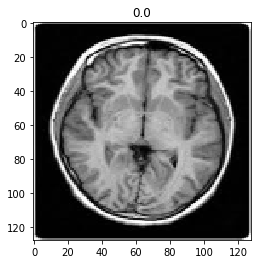

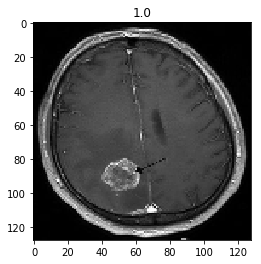

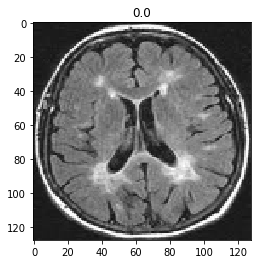

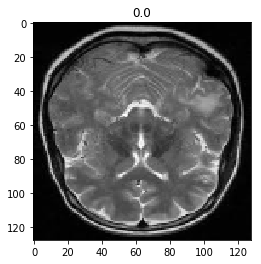

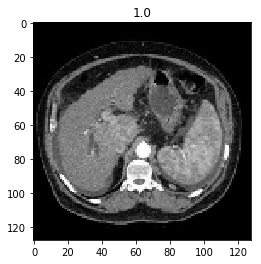

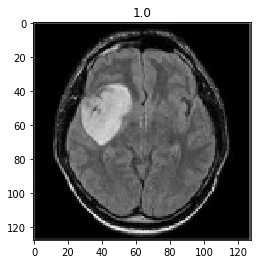

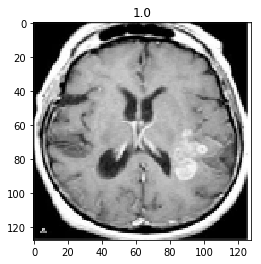

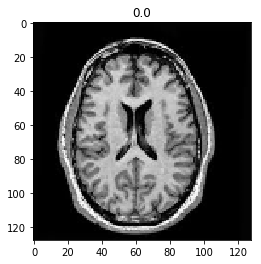

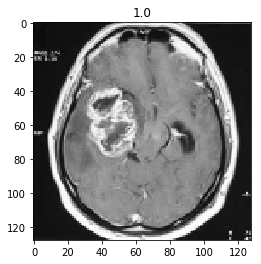

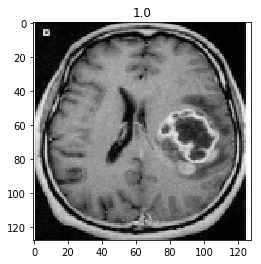

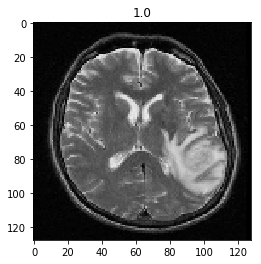

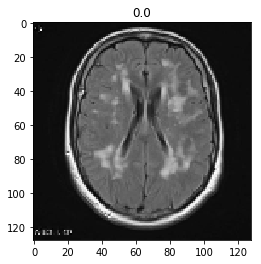

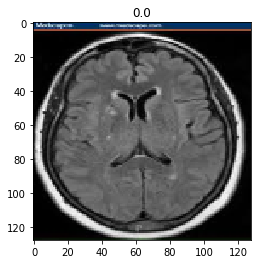

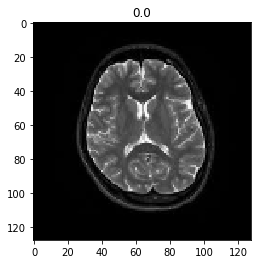

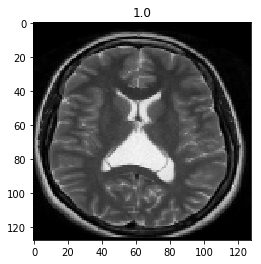

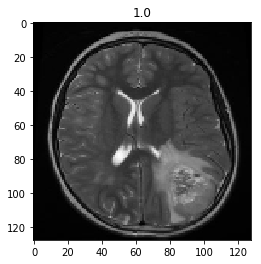

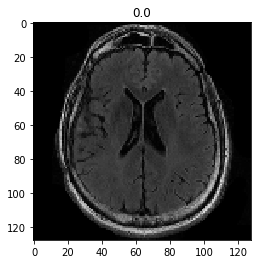

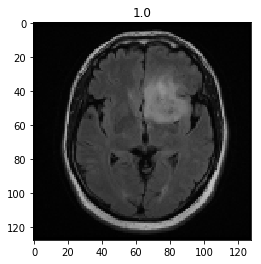

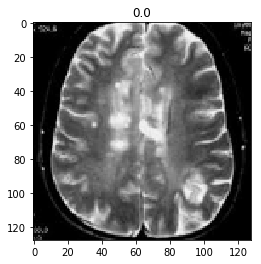

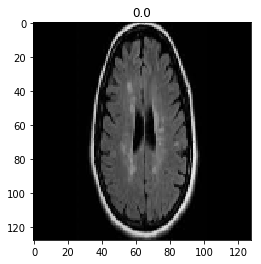

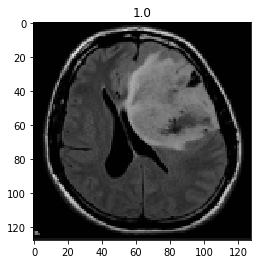

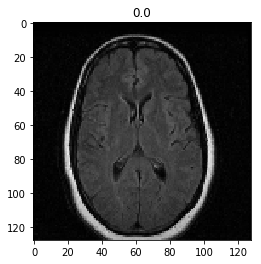

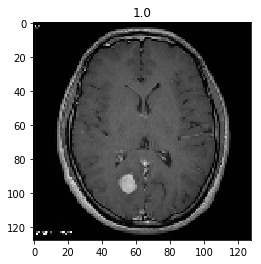

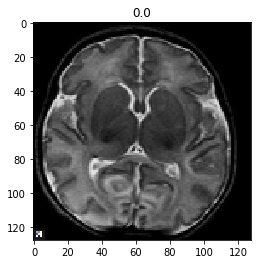

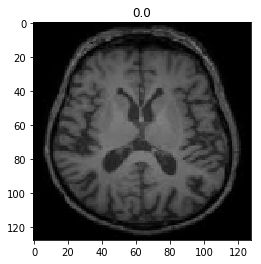

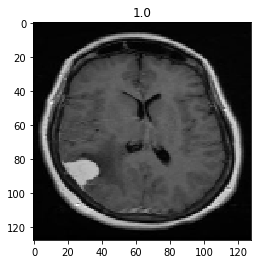

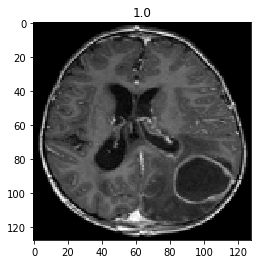

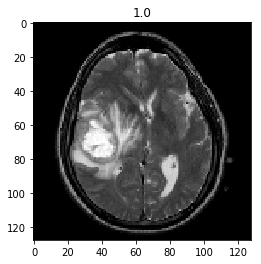

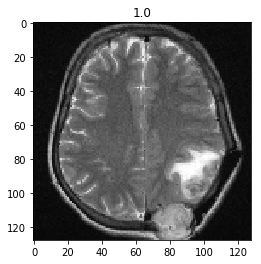

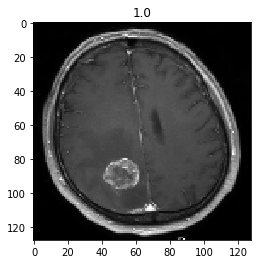

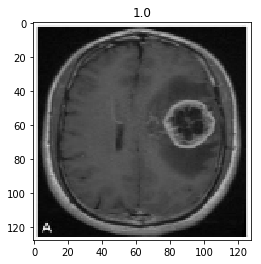

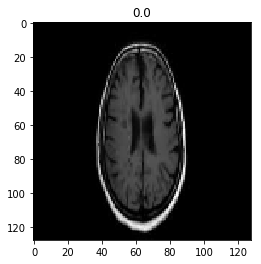

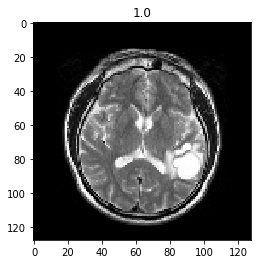

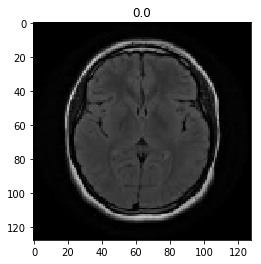

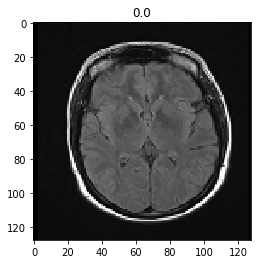

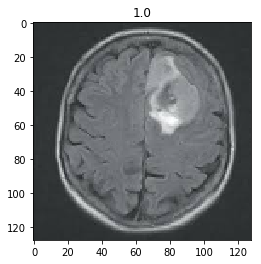

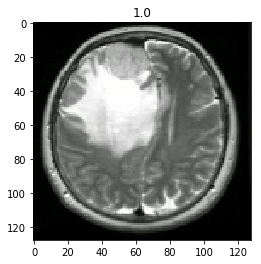

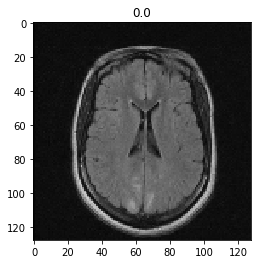

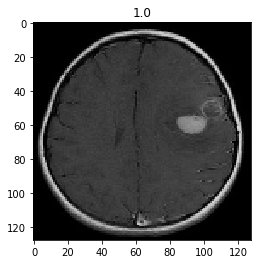

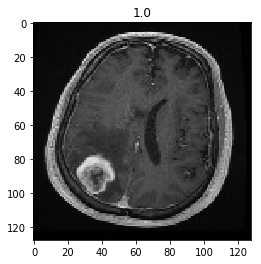

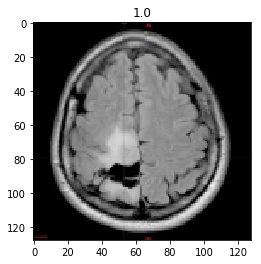

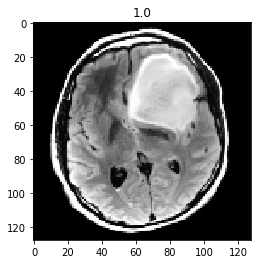

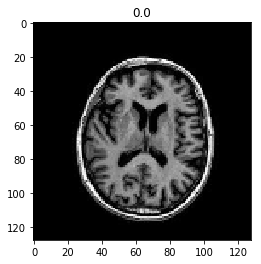

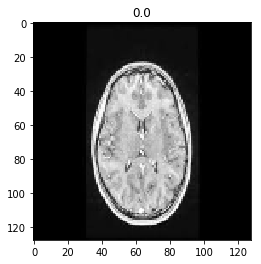

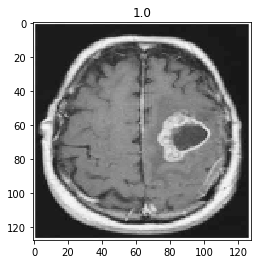

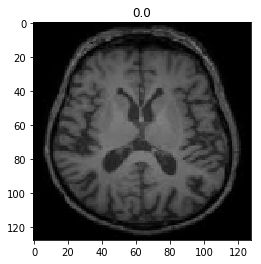

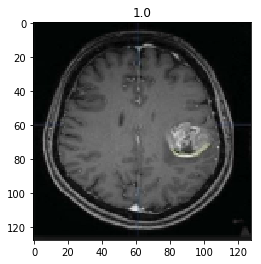

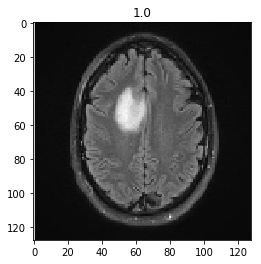

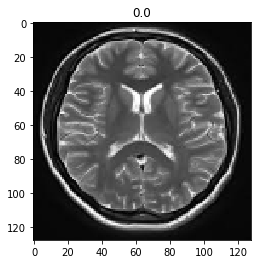

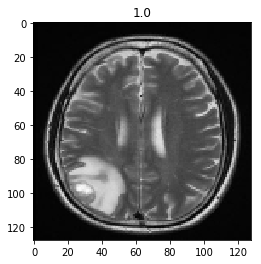

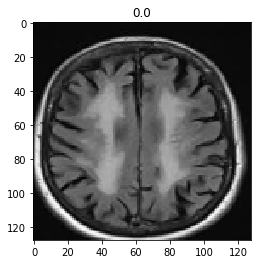

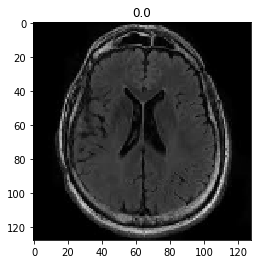

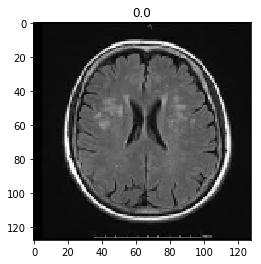

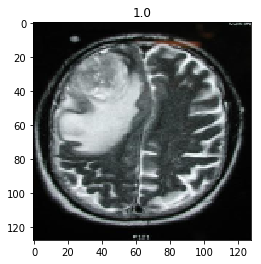

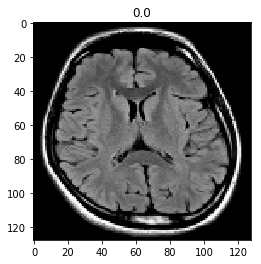

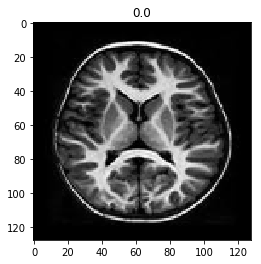

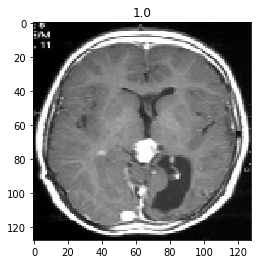

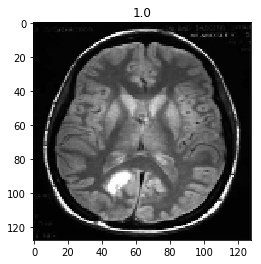

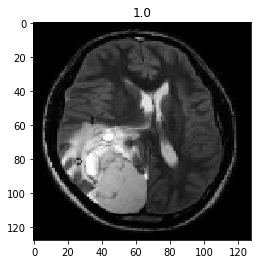

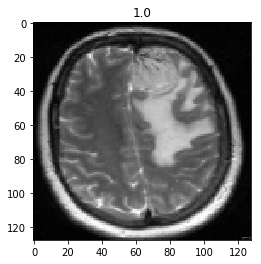

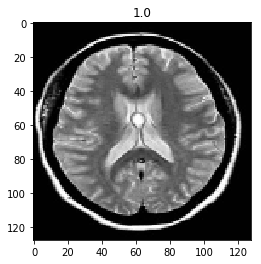

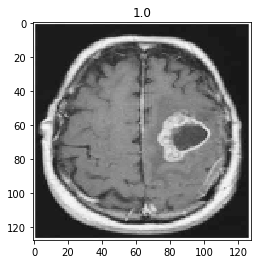

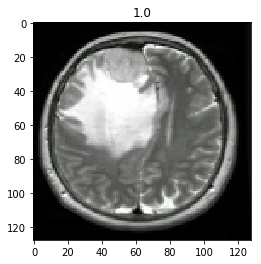

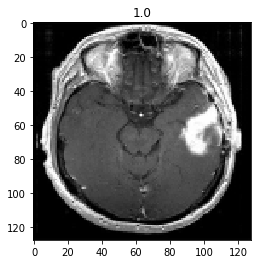

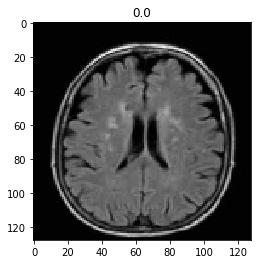

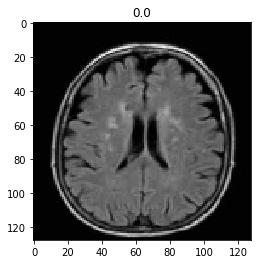

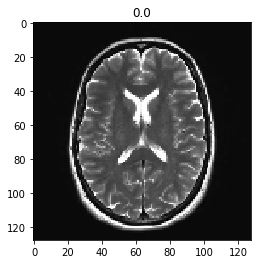

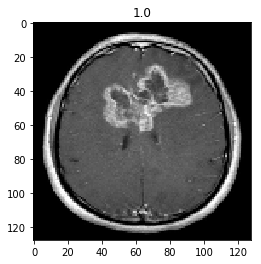

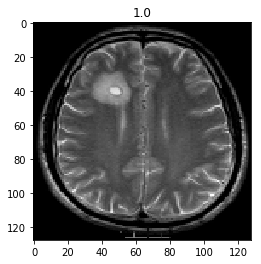

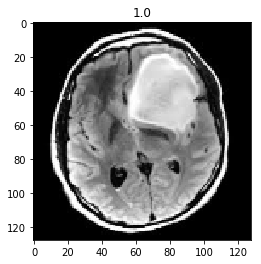

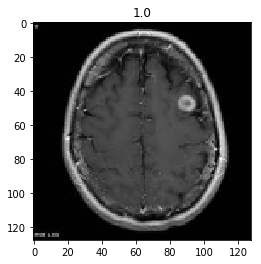

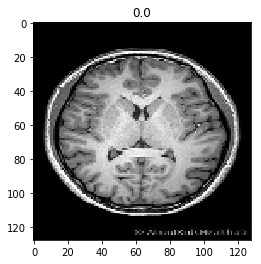

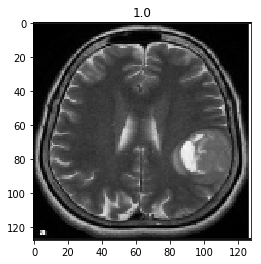

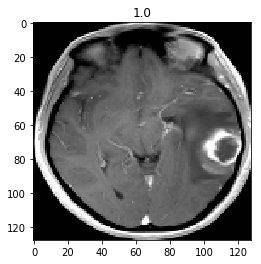

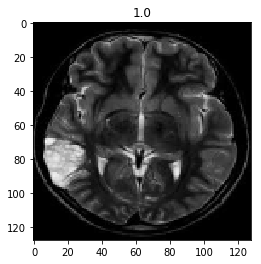

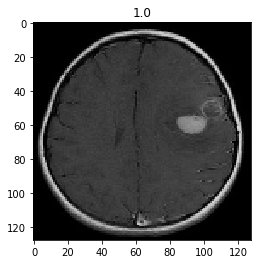

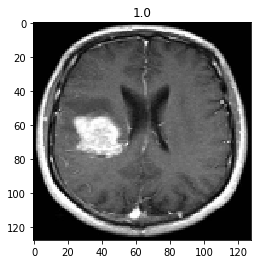

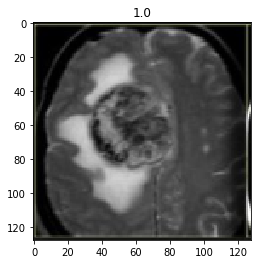

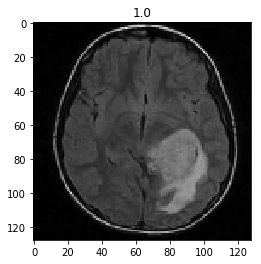

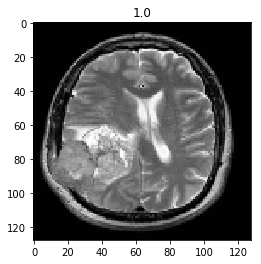

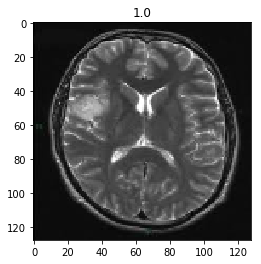

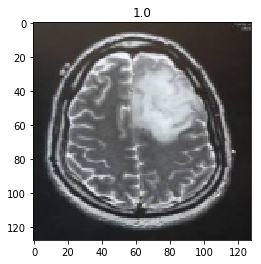

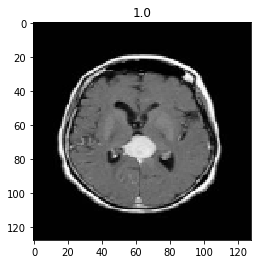

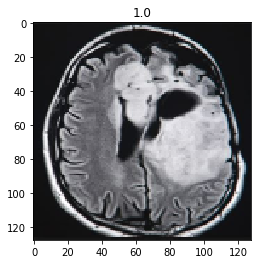

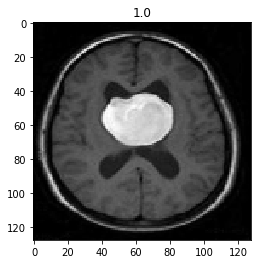

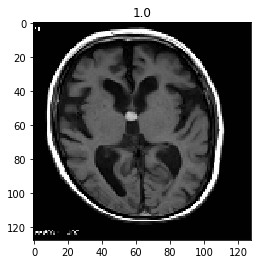

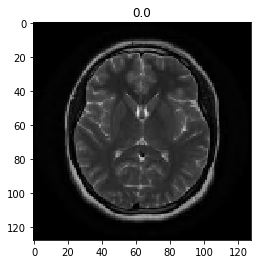

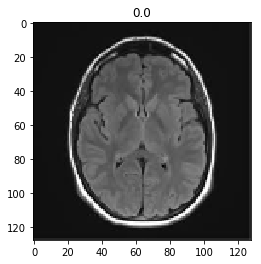

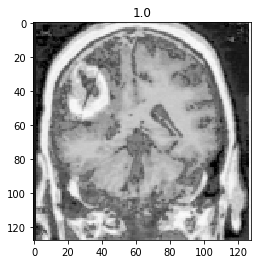

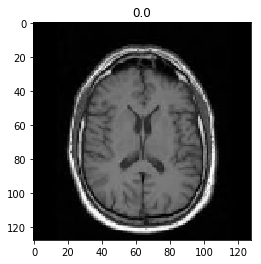

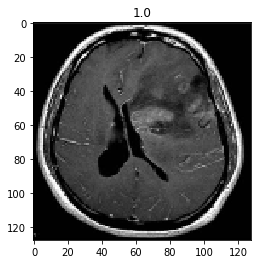

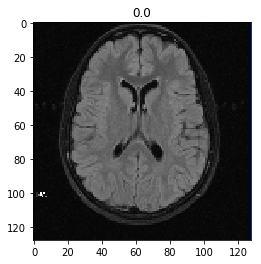

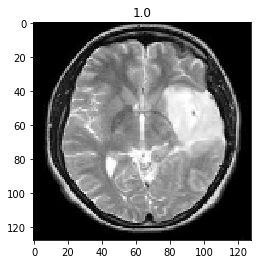

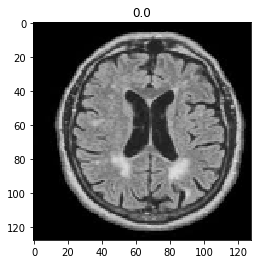

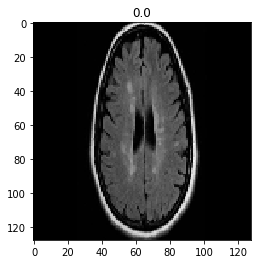

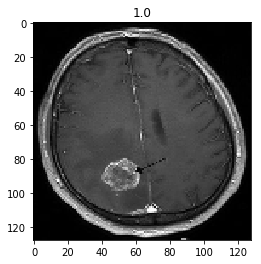

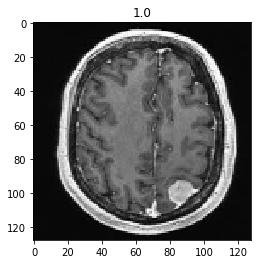

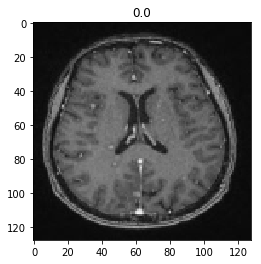

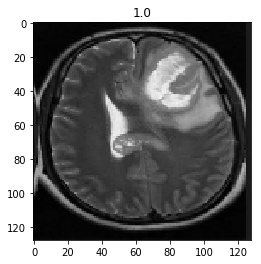

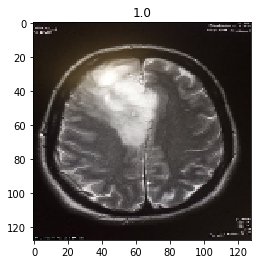

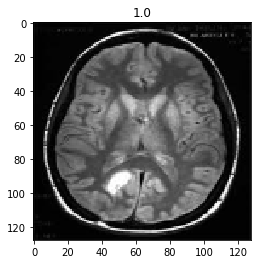

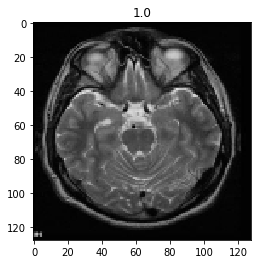

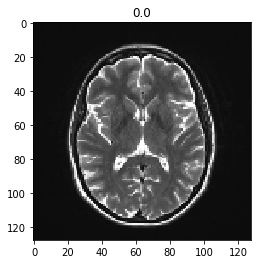

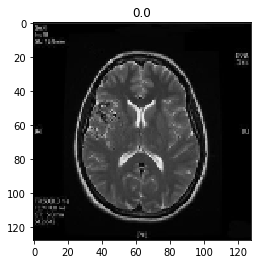

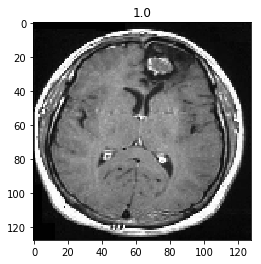

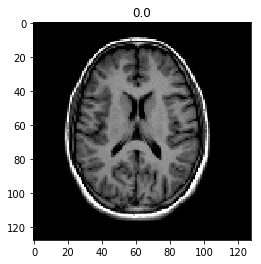

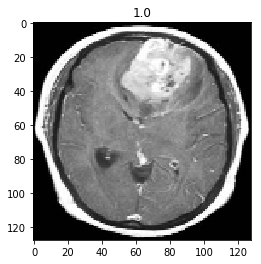

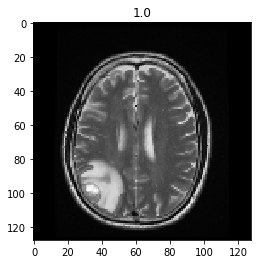

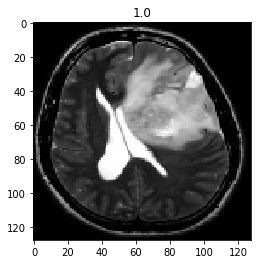

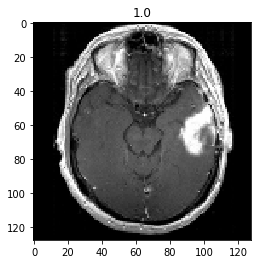

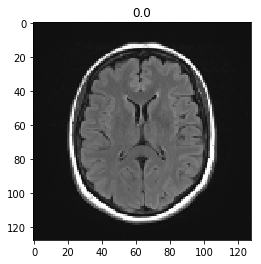

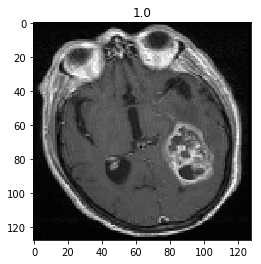

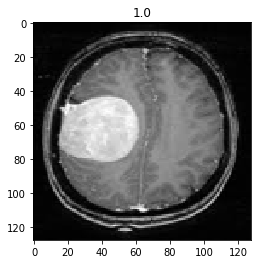

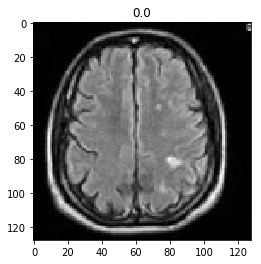

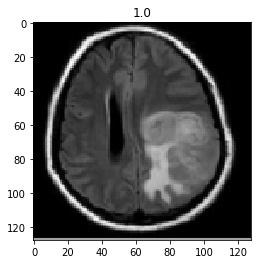

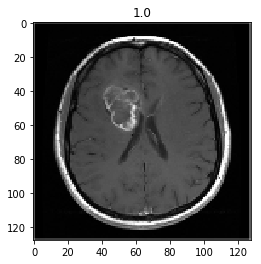

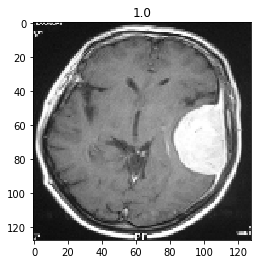

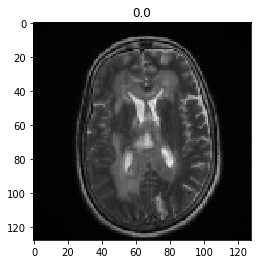

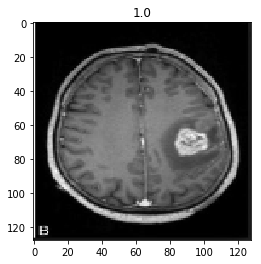

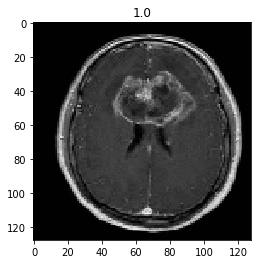

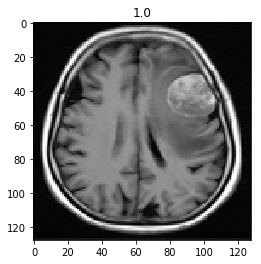

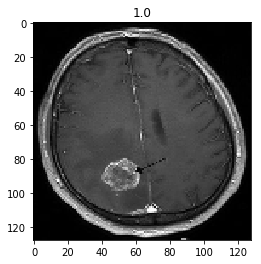

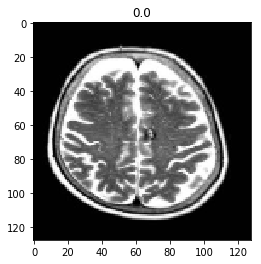

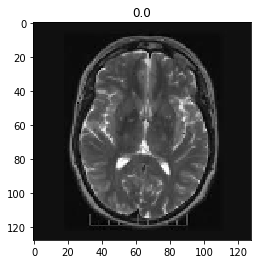

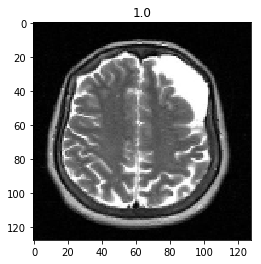

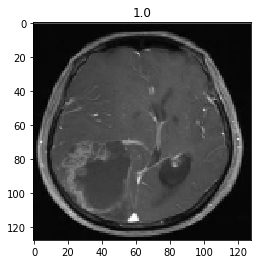

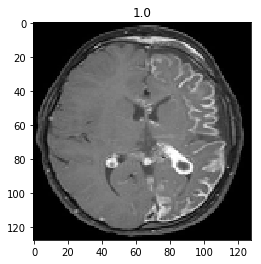

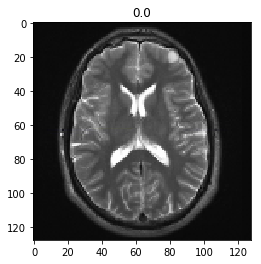

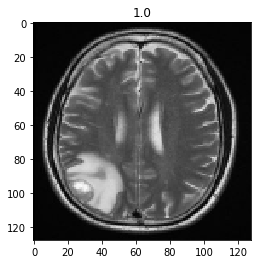

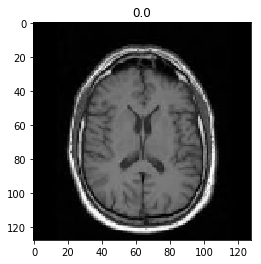

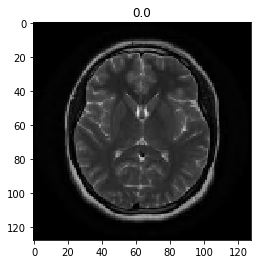

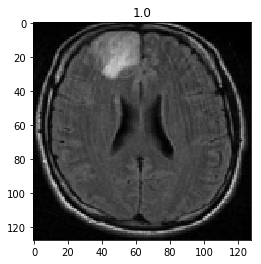

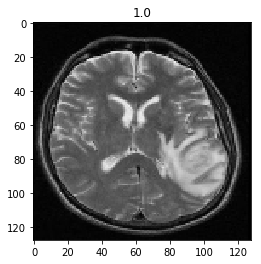

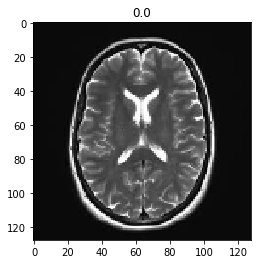

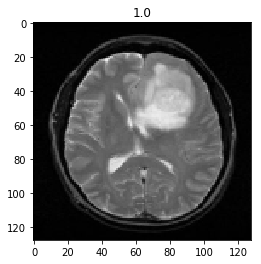

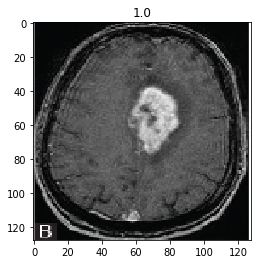

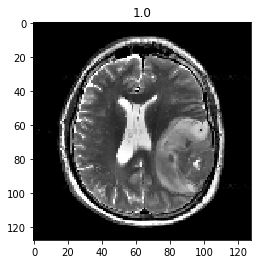

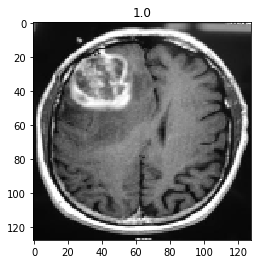

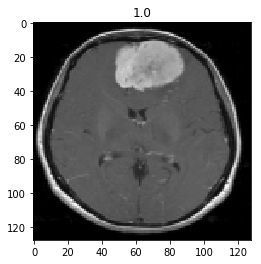

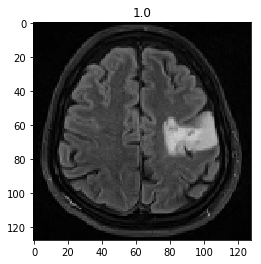

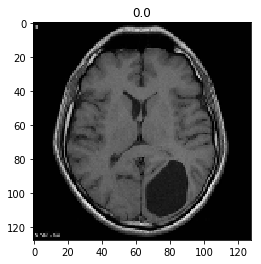

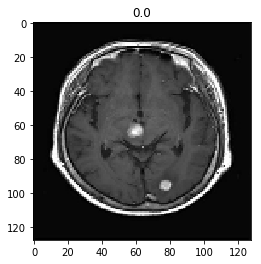

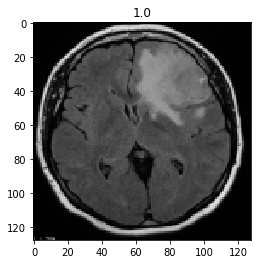

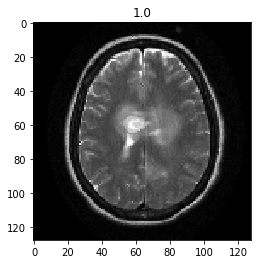

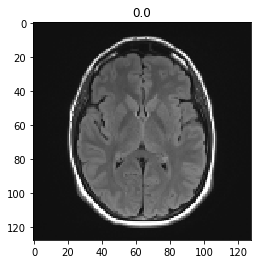

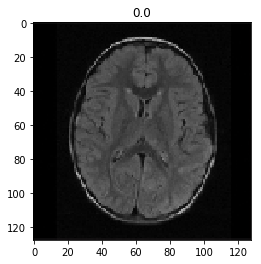

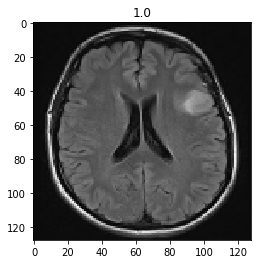

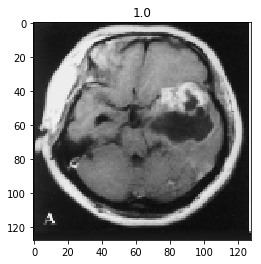

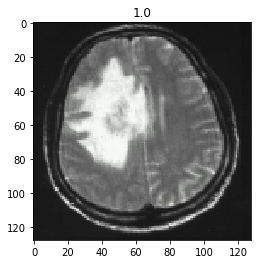

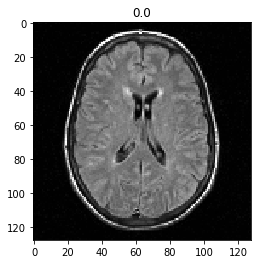

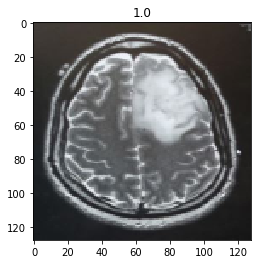

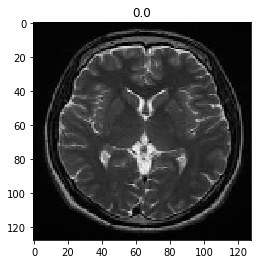

In [13]:
index=list(range(len(mri)))
random.shuffle(index)
for i in index:
    sample = mri[i]
    img = sample['image']
    label = sample['label']
    img = img.reshape(img.shape[0],img.shape[1],img.shape[2])
    plt.title(label)
    plt.imshow(img)
    plt.show()

# Create a model

In [56]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

In [15]:
model = CNN()

In [16]:
model 

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [17]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

In [18]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [19]:
model.fc_model

Sequential(
  (0): Linear(in_features=256, out_features=120, bias=True)
  (1): Tanh()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): Tanh()
  (4): Linear(in_features=84, out_features=1, bias=True)
)

In [60]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu:0')

model = CNN().to(device)

In [61]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [62]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    

RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[32, 128, 128, 3] to have 3 channels, but got 128 channels instead